In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
import LinearAlgebra: ldiv!, dot
using Test
using ForwardDiff
using SpecialFunctions
using BenchmarkTools
using QuadGK
using AdaptiveTransportMap: transform!, evaluate, ncoeff, optimize, negative_log_likelihood!
using Distributions
using Random
using LoopVectorization
using Optim
using NLsolve
using Polynomials
using MLDataUtils
using Test
using ProgressMeter

In [3]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

In [4]:
c_truth = colorant"lightseagreen" 
c_post = colorant"seagreen3"
# c_enkf = colorant"chartreuse3" 
c_enkf = colorant"orangered2"
c_smap0 = RGB(0.686,0.624,0.11)
# c_smap1 = colorant"steelblue"
c_smap1 = colorant"navy"
# c_smap1 = colorant"purple"
c_smap2 = colorant"dark red"

In [5]:
ρ =  0.9
a = 1.15
b = 0.5
Σ = [1.0 ρ; ρ 1.0]
Dbanana = MvNormal(zeros(2), Σ)

G(x) = [a*x[1]; x[2]/a - b*(x[1]^2 + a^2)]
Ginv(y) = [y[1]/a; a*y[2] + b*(y[1]^2/a + a^3)]

Ginv (generic function with 1 method)

In [6]:
banana_pdf(y) = 1/(2*π*√(det(Σ)))*exp(-0.5*Ginv(y)'*inv(Σ)*Ginv(y))

banana_pdf (generic function with 1 method)

## Exact inference

In [324]:
Ne = 500
Nx = 2
m = 20

X = hcat([G(rand(Dbanana)) for i=1:Ne]...)
X0 = copy(X)

2×500 Array{Float64,2}:
 -0.0833126   1.37414    1.35265   …  -0.296864  -0.470183  -1.25868
 -0.541637   -0.830929  -0.454353     -0.92054   -0.964621  -1.52902

In [339]:
Nplot = 50;

In [340]:
Nlogx = 100
Nlogy = 100

yrange = range(-6.0; stop = 4.0, length = Nlogy)
xrange = range(-4.0; stop = 4.0, length = Nlogx)

-4.0:0.08080808080808081:4.0

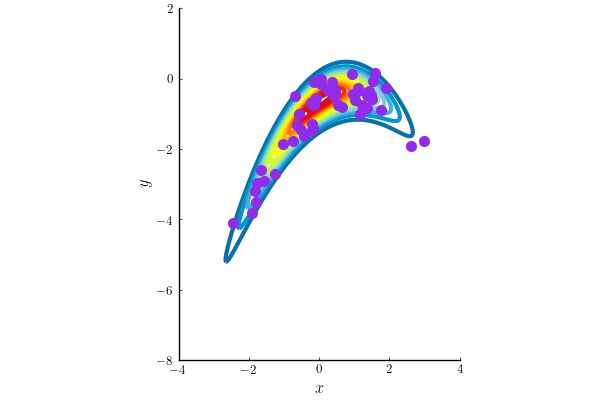

In [341]:
xrange = -4.0:0.01:4.0
yrange = -8.0:0.01:2.0
contour(xrange, yrange, (y1,y2)->banana_pdf([y1;y2]), 
        xlabel = L"x", ylabel = L"y", ratio = 1.0, colorbar = false, legend = false,
        color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
        xlim = (-Inf, Inf), ylim = (-Inf, Inf), linewidth = 3)
scatter!(X[1,1:Nplot], X[2,1:Nplot], color = :purple2, markersize = 8, markerstrokewidth=0)

In [ ]:
plot()

## Approximate inference

In [7]:
Ne = 500
Nx = 2
m = 20

Xflip = hcat([G(rand(Dbanana)) for i=1:Ne]...)

X = zero(Xflip)
X[1,:] .= copy(Xflip[2,:])
X[2,:] .= copy(Xflip[1,:])
# X = copy(Xflip)
X0 = copy(X)

2×500 Array{Float64,2}:
 -0.0154654  -1.28757  -0.293353   …  -0.656867  0.270629  -0.695868
  0.806016   -1.16455  -0.0381502     -0.634734  0.247837   0.368658

In [376]:
Nplot = 10;

In [377]:
using JLD

In [378]:
# save("banana.jld", "X", X, "Ne", Ne)

In [379]:
X = load("banana.jld", "X")

2×500 Array{Float64,2}:
 -0.0154654  -1.28757  -0.293353   …  -0.656867  0.270629  -0.695868
  0.806016   -1.16455  -0.0381502     -0.634734  0.247837   0.368658

In [525]:
Nlogx = 200
Nlogy = 200

yrange = range(-6.0; stop = 3.0, length = Nlogy)
xrange = range(-4.0; stop = 4.0, length = Nlogx)

-4.0:0.04020100502512563:4.0

In [381]:
# contour(yrange, xrange, (y1,y2)->banana_pdf([y1;y2]),    
#    xlabel = L"x", ylabel = L"y", colorbar = false,
#     clim = (0.05, Inf),
#    color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
#    xlim = (-Inf, Inf), ylim = (-Inf, Inf), linewidth = 3)
# scatter!(X[2,1:Nplot], X[1,1:Nplot], color = :purple2, markersize = 8, markerstrokewidth=0, legend = false)

In [382]:
M = HermiteMap(m, X; diag = true);

In [383]:
optimize(M, X, "kfold"; withqr = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


HermiteMap(20, 2, LinearTransform(2, [-1.13069491538092, -0.008513206484622803], [1.1549555973238734 0.0; 0.0 1.117418025254564], true), MapComponent[Map component of dimension 1 with Nψ 9 active features
, Map component of dimension 2 with Nψ 10 active features
])

In [384]:
logbanana_approx = zeros(Nlogy, Nlogx)
@showprogress for (i,y) in enumerate(yrange)
    for (j,x) in enumerate(xrange)
        logbanana_approx[i,j] = log_pdf(M, reshape([y; x], (2,1)))[1]
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


In [526]:
pdfbanana_exact = zeros(Nlogy, Nlogx)
@showprogress for (i,y) in enumerate(yrange)
    for (j,x) in enumerate(xrange)
        pdfbanana_exact[i,j] = banana_pdf([y; x])
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


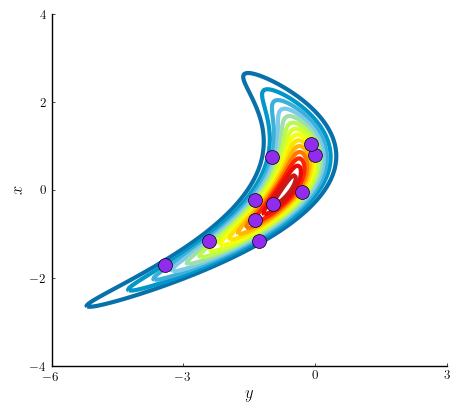

In [527]:
plt = plot(colorbar = false, grid = false, legend = false)
contour!(plt, yrange, xrange, (y1,y2)->banana_pdf([y2;y1]), ratio = 1,
   xlabel = L"y", ylabel = L"x",
   color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
   xlim = (-Inf, Inf), ylim = (-Inf, Inf), linewidth = 3)
scatter!(X[1,1:Nplot], X[2,1:Nplot], color = :purple2, markersize = 10, markerstrokewidth = 0.5)
savefig("pdfjoint.pdf")

In [386]:
My = HermiteMap(m, X[1:1,:])      
Mx = HermiteMap(m, X[2:2,:])

HermiteMap(20, 1, LinearTransform(1, [-0.008513206484622794], [1.1174180252545645], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
])

In [387]:
optimize(My,  X[1:1,:], "kfold"; withqr = true)
optimize(Mx,  X[2:2,:], "kfold"; withqr = true)

HermiteMap(20, 1, LinearTransform(1, [-0.008513206484622794], [1.1174180252545645], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
])

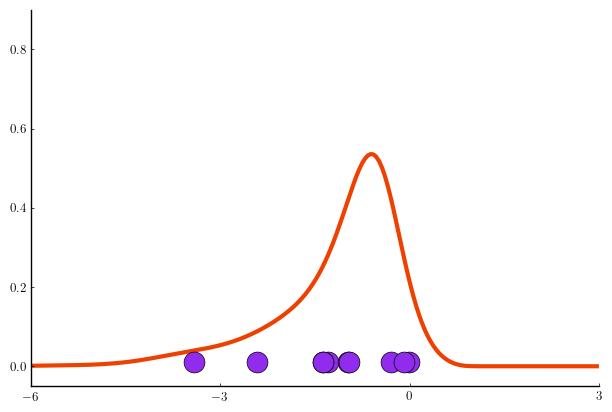

In [535]:
plot(yrange, exp.(log_pdf(My, Matrix(yrange')) .+ log(1/(M.L.L.diag[1]))), 
     linewidth = 3, legend = false, color = :orangered2, xlim = (-6.0, 3.0), ylim = (-0.05, 0.9))
scatter!(X[1,1:Nplot], 0.01*ones(Nplot), color = :purple2, markersize = 15, markerstrokewidth = 0.5)
savefig("pdfy.pdf")

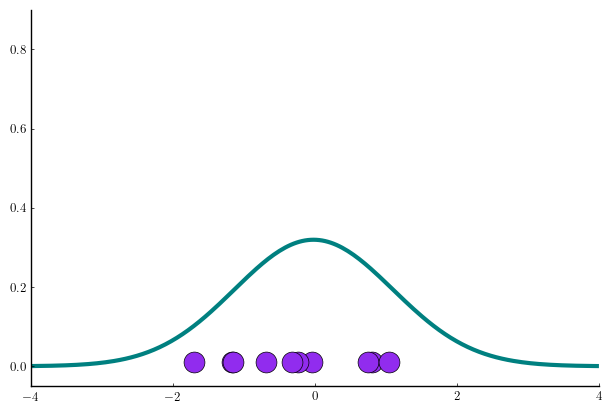

In [389]:
plot(xrange, exp.(log_pdf(Mx, Matrix(xrange')) .+ log(1/(M.L.L.diag[2]))), 
     linewidth = 3, legend = false, color = :teal, xlim = (-Inf, Inf), ylim = (-0.05, 0.9))
scatter!(X[2,1:Nplot], 0.01*ones(Nplot), color = :purple2, markersize = 15, markerstrokewidth = 0.5)
savefig("pdfxprior.pdf")

In [434]:
F = deepcopy(evaluate(M, X; start = 2))
F0 = copy(F)

2×500 Array{Float64,2}:
 0.0        0.0       0.0       0.0       …   0.0      0.0       0.0
 0.105731  -1.78462  -0.867019  0.259494     -1.5073  -0.323099  0.0920067

In [435]:
ystar = -1.5
Ystarprime = ystar*ones(1, Ne)

1×500 Array{Float64,2}:
 -1.5  -1.5  -1.5  -1.5  -1.5  -1.5  …  -1.5  -1.5  -1.5  -1.5  -1.5  -1.5

In [436]:
Xpost = deepcopy(X)

2×500 Array{Float64,2}:
 -0.0154654  -1.28757  -0.293353   …  -0.656867  0.270629  -0.695868
  0.806016   -1.16455  -0.0381502     -0.634734  0.247837   0.368658

In [437]:
# Generate posterior samples
@time inverse!(F, M, Xpost, Ystarprime; apply_rescaling = true, start = 2)

converged(result) = true
  0.006091 seconds (8.65 k allocations: 11.520 MiB)


2×500 Array{Float64,2}:
 -1.5       -1.5      -1.5       -1.5       …  -1.5      -1.5       -1.5
 -0.548408  -1.28323  -0.981588  -0.464863     -1.19969  -0.758108  -0.555642

In [438]:
Xpost

2×500 Array{Float64,2}:
 -1.5       -1.5      -1.5       -1.5       …  -1.5      -1.5       -1.5
 -0.548408  -1.28323  -0.981588  -0.464863     -1.19969  -0.758108  -0.555642

In [439]:
evaluate(M, Xpost[:,1:2]; apply_rescaling = true, start = 2)

2×2 Array{Float64,2}:
 0.0        0.0
 0.105731  -1.78462

In [440]:
F

2×500 Array{Float64,2}:
  0.0        0.0       0.0       0.0       …   0.0       0.0       0.0
 -0.878215  -2.76856  -1.85097  -0.724451     -2.49124  -1.30704  -0.891939

In [441]:
getidx(M[2])

10×2 Array{Int64,2}:
 1  0
 2  0
 0  1
 0  2
 3  0
 0  3
 0  4
 0  5
 0  6
 0  7

In [442]:
Xpostplot = zeros(2, Nlogx)
Xpostplot[1,:] .= ystar
Xpostplot[2,:] .= collect(xrange)

200-element view(::Array{Float64,2}, 2, :) with eltype Float64:
 -4.0
 -3.959798994974874
 -3.919597989949749
 -3.879396984924623
 -3.8391959798994977
 -3.798994974874372
 -3.758793969849246
 -3.7185929648241207
 -3.678391959798995
 -3.6381909547738696
 -3.5979899497487438
 -3.557788944723618
 -3.5175879396984926
  ⋮
  3.557788944723618
  3.5979899497487438
  3.6381909547738696
  3.678391959798995
  3.7185929648241207
  3.758793969849246
  3.798994974874372
  3.8391959798994977
  3.879396984924623
  3.919597989949749
  3.959798994974874
  4.0

In [443]:
log_pdfpost = log_pdf(M, Xpostplot, 2);

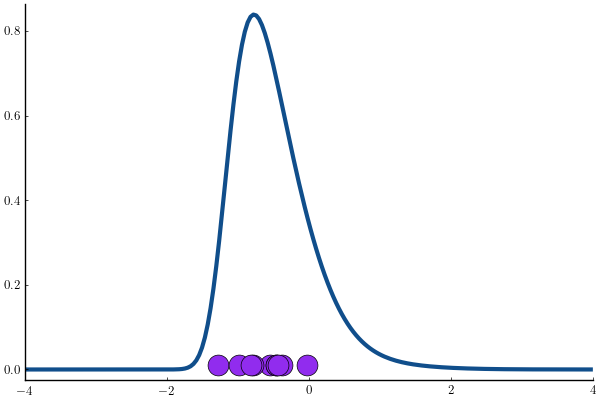

In [529]:
plot(xrange, exp.(log_pdfpost), linewidth = 3, color = :dodgerblue4, legend = false, xlim = (-Inf, Inf))
scatter!(Xpost[2,1:Nplot], 0.01*ones(Nplot), color = :purple2, markersize = 15, markerstrokewidth = 0.5)
# savefig("pdfxpost.pdf")

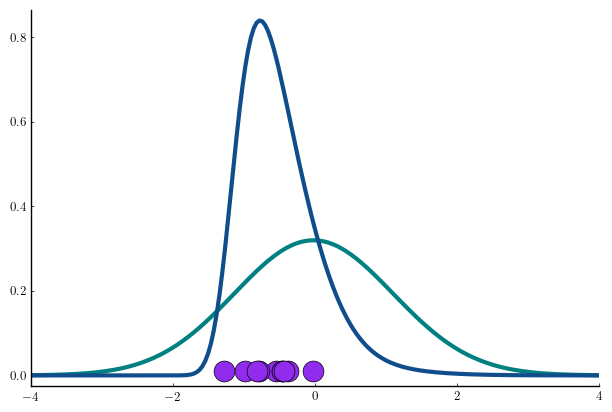

In [477]:
plot(xrange, exp.(log_pdf(Mx, Matrix(xrange')) .+ log(1/(M.L.L.diag[2]))), linewidth = 3, color = :teal, legend = false, xlim = (-Inf, Inf))
plot!(xrange, exp.(log_pdfpost), linewidth = 3, color = :dodgerblue4)
scatter!(Xpost[2,1:Nplot], 0.01*ones(Nplot), color = :purple2, markersize = 15, markerstrokewidth = 0.5)
savefig("pdfxpriorpost.pdf")

In [446]:
Xnormal = randn(2,Ne);

In [447]:
Mnormal = HermiteMap(m, Xnormal; diag = true);

In [448]:
optimize(Mnormal, Xnormal, "kfold"; withconstant = false, withqr = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


HermiteMap(20, 2, LinearTransform(2, [-0.054102448490805935, 0.03554248295950596], [0.986386004561266 0.0; 0.0 0.9954587356349983], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
])

In [449]:
lognormal_approx = zeros(Nlogy, Nlogx)
@showprogress for (i,y) in enumerate(yrange)
    for (j,x) in enumerate(xrange)
        lognormal_approx[i,j] = log_pdf(Mnormal, reshape([y; x], (2,1)))[1]
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


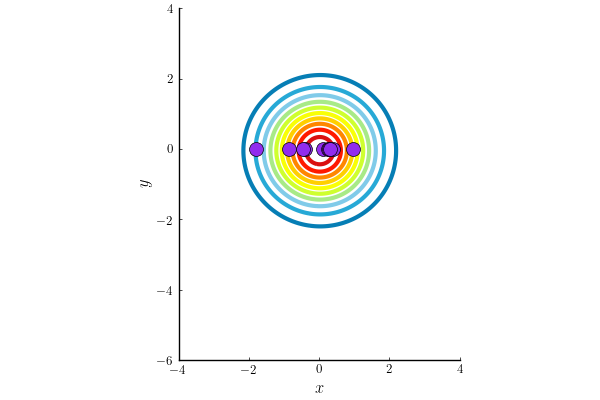

In [450]:
plt = plot(colorbar = false, grid = false, legend = false)
contour!(plt, xrange, yrange, exp.(lognormal_approx), ratio = 1,
   xlabel = L"x", ylabel = L"y",
   color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
   xlim = (-Inf, Inf), ylim = (-Inf, Inf), linewidth = 3)
scatter!(F0[2,1:Nplot], F0[1,1:Nplot], color = :purple2, markersize = 10, markerstrokewidth = 0.5)
# savefig

In [430]:
M.L

LinearTransform(2, [-1.13069491538092, -0.008513206484622803], [1.1549555973238734 0.0; 0.0 1.117418025254564], true)

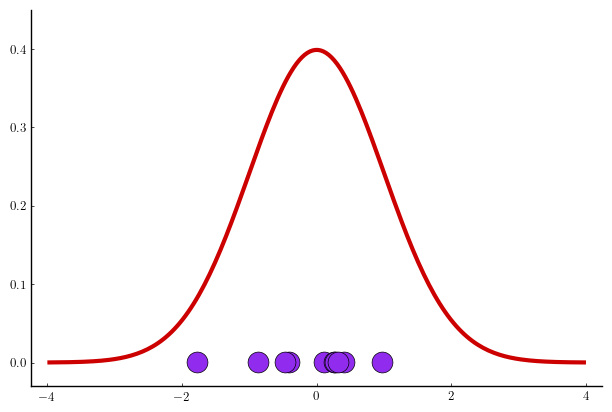

In [486]:
plt = plot(colorbar = false, grid = false, legend = false)
plot!(plt, xrange, pdf.(Normal(), xrange), linewidth = 3, color = :red3)
scatter!(F0[2,1:Nplot], 0.0001*ones(Nplot), color = :purple2, markersize = 15, markerstrokewidth = 0.5, ylim = (-0.03, 0.45))
savefig("sxsamples.pdf")

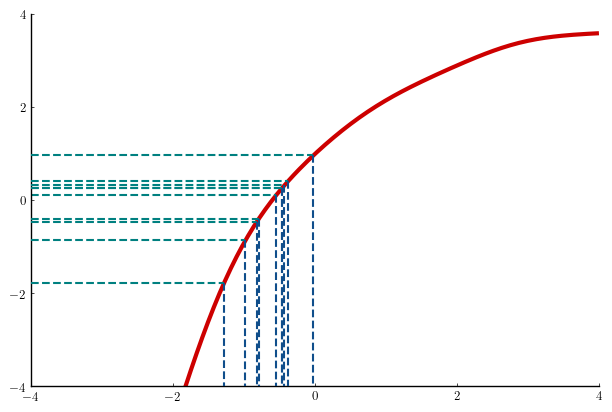

In [534]:
plt = plot(xlim = (-4.0, 4.0), ylim = (-4.0, 4.0), legend = false)
plot!(plt, xrange, evaluate(M, Xpostplot)[2,:], linewidth = 3, color = :red3)
for i=1:Nplot
    plot!(plt, [-4.0; Xpost[2,i]], [F0[2, i]; F0[2, i]], color = :teal, linestyle = :dash, linewidth = 1.5)
    plot!(plt, [Xpost[2,i]; Xpost[2,i]], [F0[2, i]; -4.0], color = :dodgerblue4, linestyle = :dash, linewidth = 1.5)
end
plt
savefig("inversion.pdf")
# scatter!(plt, -4.0*ones(Nplot), F0[2, 1:Nplot], color = :purple2, markersize = 15, markerstrokewidth = 0.5)
# scatter!(plt, Xpost[2,1:Nplot], -9.0*ones(Nplot), color = :purple2, markersize = 15, markerstrokewidth = 0.5)

In [292]:
evaluate(M, Xpost)

2×500 Array{Float64,2}:
 -0.659733  -0.659733  -0.659733  …  -0.659733  -0.659733  -0.659733
  0.105731  -1.78462   -0.867019     -1.5073    -0.323099   0.0920067

In [433]:
F

2×500 Array{Float64,2}:
  0.0        0.0       0.0       0.0       …   0.0       0.0       0.0
 -0.878215  -2.76856  -1.85097  -0.724451     -2.49124  -1.30704  -0.891939

In [411]:
evaluate(M, Xpost)

2×500 Array{Float64,2}:
 -0.659733  -0.659733  -0.659733  …  -0.659733  -0.659733  -0.659733
  0.105731  -1.78462   -0.867019     -1.5073    -0.323099   0.0920067

In [251]:
F[2,:]

500-element Array{Float64,1}:
 -1.7661105090140783
 -3.6564593949887225
 -2.7388605187446
 -1.6123467241124785
 -1.4676990755399852
 -2.2797755119003122
 -0.9075231290233708
 -2.338401552618235
 -1.6057283312402428
 -1.5561877025013384
 -1.3213764152136254
 -2.3145089364358706
 -1.977759609382031
  ⋮
 -1.6769326780220277
 -2.733835474731307
 -1.5539325856758341
 -2.857752908378311
 -0.825431626188494
 -2.19545900751247
 -2.2069566192787127
 -2.086049784174346
 -3.362412459589152
 -3.3791389696548966
 -2.1949403255927935
 -1.7798343421730798

In [34]:
findmax(exp.(log_pdfpost))

(0.5094595234189676, 109)

In [32]:
mean(Xpost[2,:])

-0.5382967202230056

In [58]:


σ = 2.0
banana = 0.3

X = sample_banana(Ne; σ = σ, bananicity = banana);
X0 = copy(X)

2×500 Array{Float64,2}:
  2.27982  5.29803  -0.173248  -0.0266256  …  -0.557136  -0.512924  0.0577943
 -1.04331  8.89392  -1.47915   -0.34          -0.488813  -2.54693   0.281956

In [59]:
# X[1,:] .= copy(X0[2,:])
# X[2,:] .= copy(X0[1,:])

In [61]:
M = HermiteMap(m, X; diag = true);

In [62]:
optimize(M, X, "kfold"; withconstant = true, withqr = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


HermiteMap(15, 2, LinearTransform(2, [0.12519993149038414, 0.010393364620488121], [2.0033216141508867 0.0; 0.0 2.0747951626712045], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 11 active features
])

In [63]:
logbanana_approx = zeros(Nlogy, Nlogx)
@showprogress for (i,y) in enumerate(yrange)
    for (j,x) in enumerate(xrange)
        logbanana_approx[i,j] = log_pdf(M, reshape([y; x], (2,1)))[1]
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


-4.0:0.08080808080808081:4.0

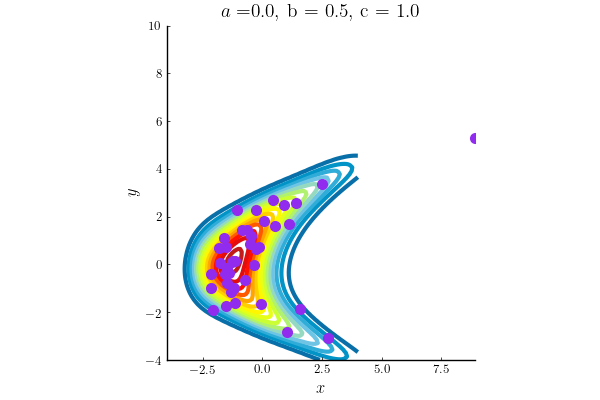

In [65]:
plt = plot(colorbar = false, grid = false, legend = false)
contour!(plt, xrange, yrange, exp.(logbanana_approx), ratio = 1,
   title = L"a = "*string(a)*", b = "*string(b)*", c = "*string(c), 
   xlabel = L"x", ylabel = L"y",
   color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
   xlim = (-Inf, Inf), ylim = (-Inf, Inf), linewidth = 3)
scatter!(X[2,1:Nplot], X[1,1:Nplot], color = :purple2, markersize = 8, markerstrokewidth=0)
# savefig("banana_3.pdf")

In [66]:
My = HermiteMap(m, X[1:1,:])      
Mx = HermiteMap(m, X[2:2,:])

HermiteMap(15, 1, LinearTransform(1, [0.010393364620488078], [2.074795162671205], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
])

In [14]:
optimize(My,  X[1:1,:], "kfold"; withqr = true)
optimize(Mx,  X[2:2,:], "kfold"; withqr = true)

HermiteMap(15, 1, LinearTransform(1, [0.26588633113042337], [1.0472703468519942], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
])

In [15]:
Mx

HermiteMap(15, 1, LinearTransform(1, [0.26588633113042337], [1.0472703468519942], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
])

In [16]:
Xflip = zero(X)
Xflip[1,:] .= X[2,:]
Xflip[2,:] .= X[1,:];

In [17]:
Mlik = HermiteMap(m, Xflip; diag = true);

In [18]:
optimize(Mlik,  Xflip, "kfold"; withqr = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


HermiteMap(15, 2, LinearTransform(2, [0.26588633113042326, -0.048619758393152065], [1.0472703468519942 0.0; 0.0 0.4970416569661714], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
])

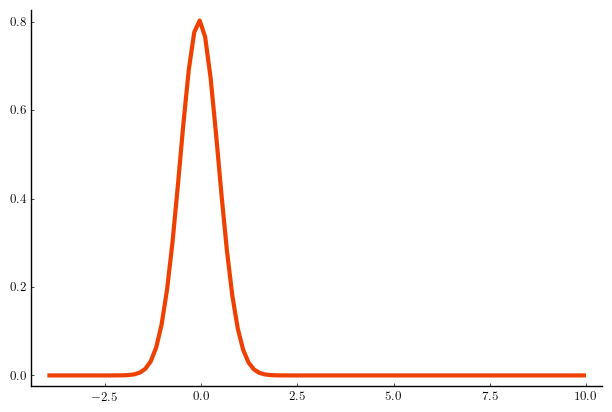

In [19]:
plot(yrange, exp.(log_pdf(My, Matrix(yrange'))), linewidth = 3, legend = false, color = :orangered2)
savefig("pdfy.pdf")

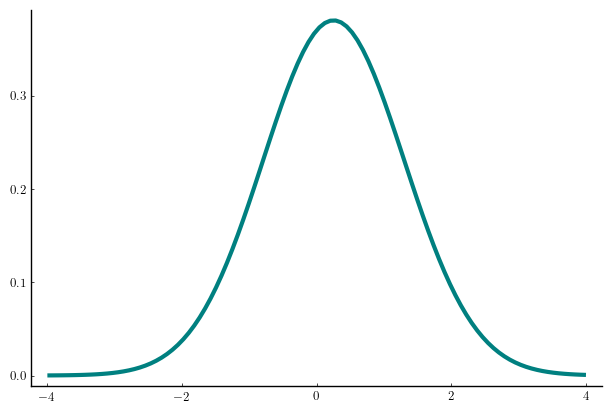

In [20]:
plot(xrange, exp.(log_pdf(Mx, Matrix(xrange'))), linewidth = 3, legend = false, color = :teal)
savefig("pdfxprior.pdf")

In [21]:
F = evaluate(M, X; start = 2)

2×500 Array{Float64,2}:
  0.0       0.0       0.0         0.0       …  0.0       0.0       0.0
 -1.70226  -0.546778  0.0290356  -0.682283     0.132983  1.99035  -0.0480695

In [22]:
ystar = 1.0
# Rescale ystar
Ystarprime = ystar*ones(1, Ne)

1×500 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [23]:
Xpost = copy(X)

2×500 Array{Float64,2}:
 -0.104588   0.290208  -0.490995  …  0.274441  -0.181118  -0.353051
 -1.67702   -0.376097   0.242954     0.236559   2.05597    0.0790152

In [201]:
# Generate posterior samples
inverse!(F, M, Xpost, Ystarprime; apply_rescaling = true, start = 2)

converged(result) = true


2×500 Array{Float64,2}:
  1.0         1.0        1.0       …  1.0        1.0        1.0
 -0.0885892  -0.048697  -0.198782     0.0746026  0.635909  -0.534846

In [202]:
Xpost

2×500 Array{Float64,2}:
  1.0         1.0        1.0       …  1.0        1.0        1.0
 -0.0885892  -0.048697  -0.198782     0.0746026  0.635909  -0.534846

In [203]:
Xpostplot = zeros(2, Nlogx)
Xpostplot[1,:] .= ystar
Xpostplot[1,:] .= collect(xrange)

100-element view(::Array{Float64,2}, 1, :) with eltype Float64:
 -4.0
 -3.919191919191919
 -3.8383838383838382
 -3.757575757575758
 -3.676767676767677
 -3.595959595959596
 -3.515151515151515
 -3.4343434343434343
 -3.3535353535353534
 -3.272727272727273
 -3.191919191919192
 -3.111111111111111
 -3.0303030303030303
  ⋮
  3.111111111111111
  3.191919191919192
  3.272727272727273
  3.3535353535353534
  3.4343434343434343
  3.515151515151515
  3.595959595959596
  3.676767676767677
  3.757575757575758
  3.8383838383838382
  3.919191919191919
  4.0

In [204]:
log_pdfpost = log_pdf(M[2], Xpostplot)

100-element Array{Float64,1}:
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
  ⋮
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567
 -0.9189968601908567

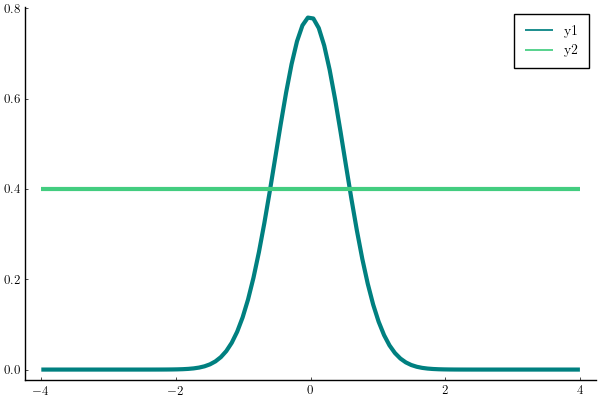

In [197]:
plot(xrange, exp.(log_pdf(Mx, Matrix(xrange'))), linewidth = 3, color = :teal)
plot!(xrange, exp.(log_pdfpost), linewidth = 3, color = :seagreen3)

In [166]:

logbanana = zeros(Nlog, Nlog)
logbanana_x = zeros(Nlog)
logbanana_y = zeros(Nlog)
logbanana_approx = zeros(Nlog, Nlog)

lognormal = zeros(Nlog, Nlog)

@showprogress for (i,x) in enumerate(xrange)
    for (j,y) in enumerate(yrange)
        logbanana[i,j] = log_pdf_banana([x;y], a = a, b = b, c = c)
        logbanana_x[i] = pdf(Normal(), a + b*x)
        logbanana_y[j] = pdf(Normal(), y - c*x^2)
        logbanana_approx[i,j] = log_pdf(M, reshape([x; y], (2,1)))[1]
        lognormal[i,j] = logpdf(MvNormal(zeros(2), 1.0), [x;y])
    end
end

LoadError: UndefVarError: Nlog not defined

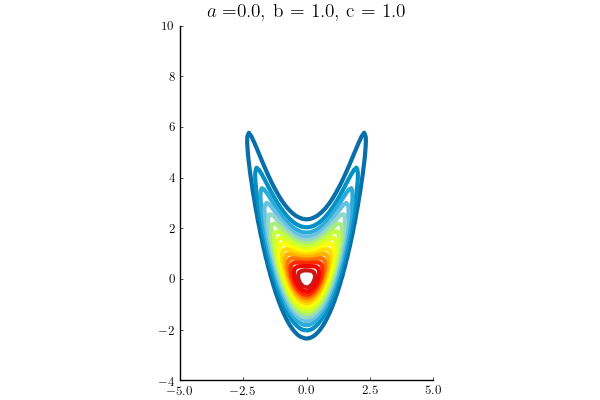

In [309]:
plt = plot(colorbar = false, grid = false)
contour!(plt, xrange, yrange, exp.(logbanana)', ratio = 1,
#          clim = (0.1, Inf),
#          levels = 9,
         title = L"a = "*string(a)*", b = "*string(b)*", c = "*string(c), 
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)
# savefig("banana_3.pdf")

In [313]:
logbanana_y

100-element Array{Float64,1}:
 9.551694541948838e-184
 5.711944525259928e-182
 3.3481317006322635e-180
 1.923694403141971e-178
 1.08338951101722e-176
 5.980646983942696e-175
 3.23613556721357e-173
 1.7164068597969757e-171
 8.923367371087355e-170
 4.547286327562482e-168
 2.271385378676386e-166
 1.1121012965730456e-164
 5.33719247371605e-163
 ⋮
 1.2128308467339581e-60
 1.2480255864845785e-59
 1.2588145114807748e-58
 1.2445575649229895e-57
 1.206099767546514e-56
 1.1456882924075832e-55
 1.0667550637979724e-54
 9.735941319405242e-54
 8.709759813873189e-53
 7.637468050723818e-52
 6.564590362221881e-51
 5.530709549844416e-50

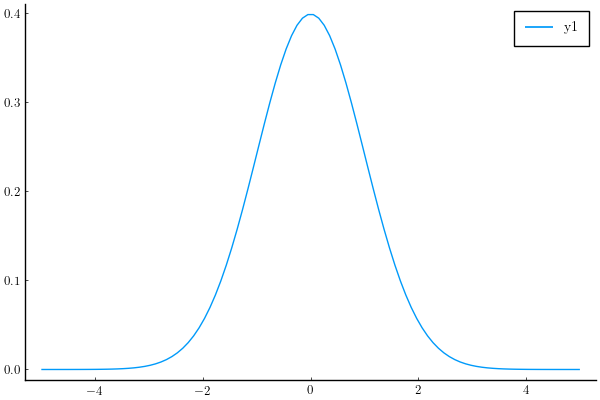

In [311]:
plot(xrange, logbanana_x)

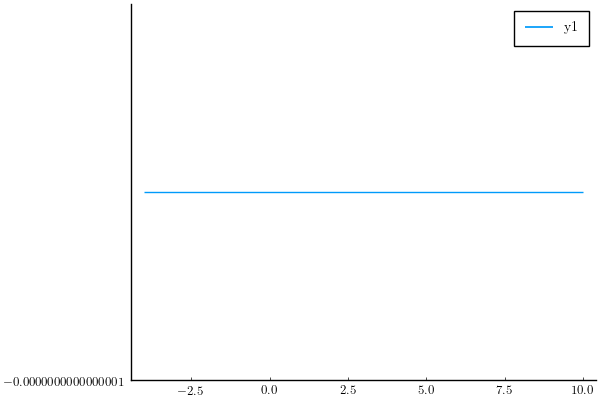

In [312]:
plot(yrange, logbanana_y)

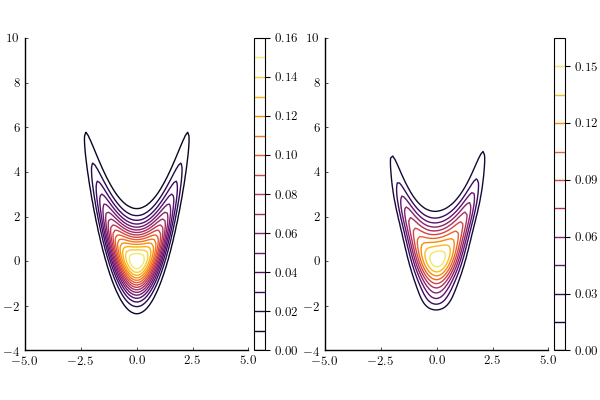

In [310]:
plt = plot(layout = grid(1,2))
contour!(plt[1,1], xrange, yrange, exp.(logbanana)', ratio = 1, xlim = (xrange[1], xrange[end]))
# scatter!(X[1,:], X[2,:]; legend = false, color = :grey)

contour!(plt[1,2], xrange, yrange, exp.(logbanana_approx)', ratio = 1, xlim = (xrange[1], xrange[end]))

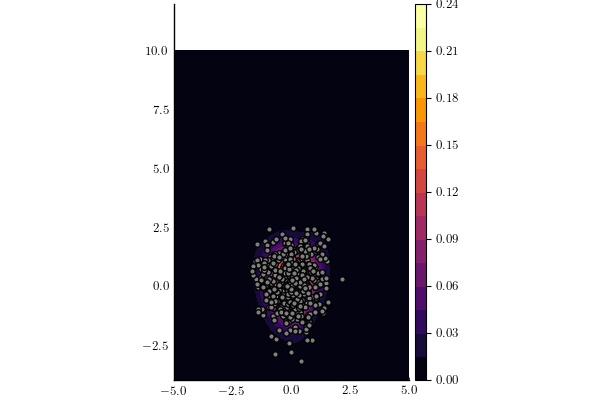

In [299]:
contourf(xrange, yrange, exp.(logbanana_approx)', ratio = 1, xlim = (-Inf, Inf), ylim = (-4, 12))
scatter!(X[1,:], X[2,:]; legend = false, color = :grey, ratio = 1)

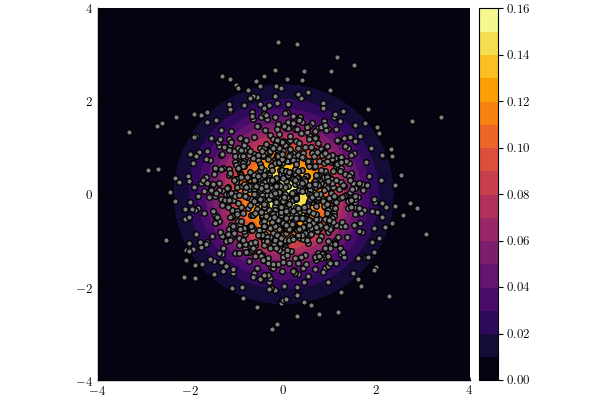

In [192]:
contourf(xrange, yrange, exp.(lognormal)', ratio = 1, xlim = (-4, 4),ylim = (-4, 4))
scatter!(MpushX[1,:], MpushX[2,:]; legend = false, color = :grey)

In [159]:
function dist_margjoint(m, X, maxterms, xrange, yrange)
    y = X[1,:]
    x = X[2,:]
    
    Mx = HermiteMap(m, Matrix(x'))
    My = HermiteMap(m, Matrix(y'))  

    Mxy = HermiteMap(m, Matrix(vcat(x', y')))

    optimize(Mx,  Matrix(x'), maxterms; withqr = true)
    optimize(My,  Matrix(y'), maxterms; withqr = true)
    optimize(Mxy, Matrix(vcat(x', y')), maxterms; withqr = true)
        
    logpdf_grid = zeros(Nlog, Nlog)


    @showprogress for (i, xi) in enumerate(xrange)
        for (j, yj) in enumerate(yrange)
            logpdf_grid[i,j] = log_pdf(Mxy, reshape([xi; yj], (2,1)))[1]
        end
    end
    @show size(getidx(Mx[1]),1), size(getidx(My[1]),1), size(getidx(Mxy[1]),1), size(getidx(Mxy[2]),1)
        
    return Mx, My, Mxy, logpdf_grid
end

dist_margjoint (generic function with 2 methods)

In [160]:
Mx, My, Mxy, logpdf_grid = dist_margjoint(m, X, "kfold");

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


(size(getidx(Mx[1]), 1), size(getidx(My[1]), 1), size(getidx(Mxy[1]), 1), size(getidx(Mxy[2]), 1)) = (10, 1, 10, 1)


In [161]:
logpdf_grid

100×100 Array{Float64,2}:
 -53.6544  -53.3078  -52.9681  -52.6355  …  -52.5733  -52.9046  -53.2429
 -52.8671  -52.5205  -52.1808  -51.8482     -51.7868  -52.1182  -52.4565
 -51.9749  -51.6283  -51.2887  -50.956      -50.8955  -51.2269  -51.5652
 -50.9313  -50.5847  -50.245   -49.9124     -49.8528  -50.1842  -50.5226
 -49.691   -49.3444  -49.0048  -48.6722     -48.6136  -48.945   -49.2834
 -48.2242  -47.8776  -47.538   -47.2054  …  -47.1479  -47.4793  -47.8177
 -46.5232  -46.1766  -45.837   -45.5044     -45.448   -45.7794  -46.1178
 -44.6016  -44.2551  -43.9155  -43.5829     -43.5277  -43.8592  -44.1976
 -42.4898  -42.1433  -41.8037  -41.4711     -41.4173  -41.7487  -42.0871
 -40.2289  -39.8823  -39.5428  -39.2102     -39.1577  -39.4891  -39.8276
 -37.866   -37.5195  -37.18    -36.8474  …  -36.7963  -37.1278  -37.4662
 -35.4506  -35.1041  -34.7646  -34.4321     -34.3825  -34.7139  -35.0524
 -33.0313  -32.6848  -32.3453  -32.0128     -31.9647  -32.2962  -32.6347
   ⋮                     

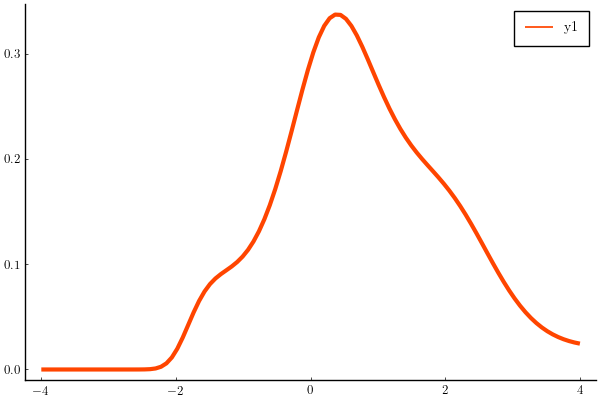

In [162]:
plot(xrange, exp.(log_pdf(Mx, Matrix(xrange'))), subplot = 1, linewidth = 3, color = :orangered)

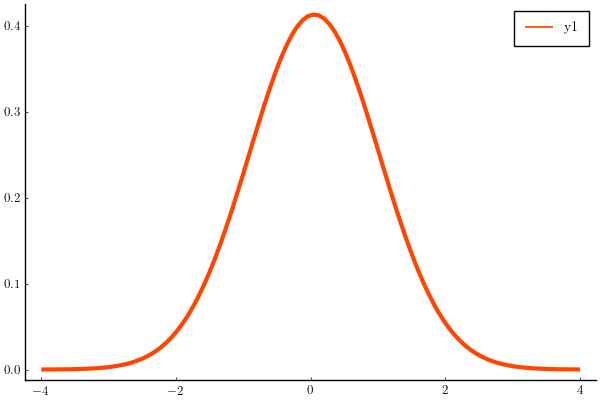

In [163]:
plot(xrange, exp.(log_pdf(My, Matrix(xrange'))), subplot = 1, linewidth = 3, color = :orangered)

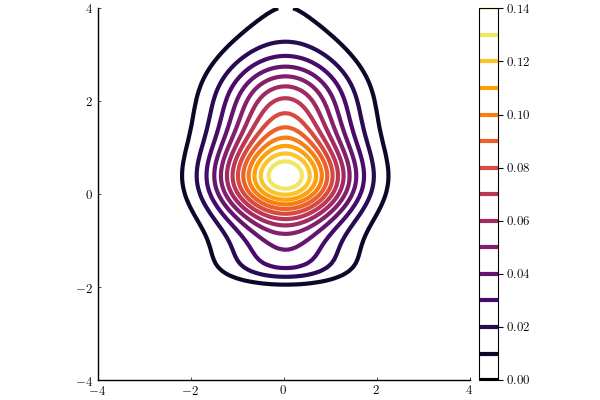

In [164]:
contour(xrange, xrange, exp.(logpdf_grid), linewidth = 3, ratio = 1.0, label = "ATM")

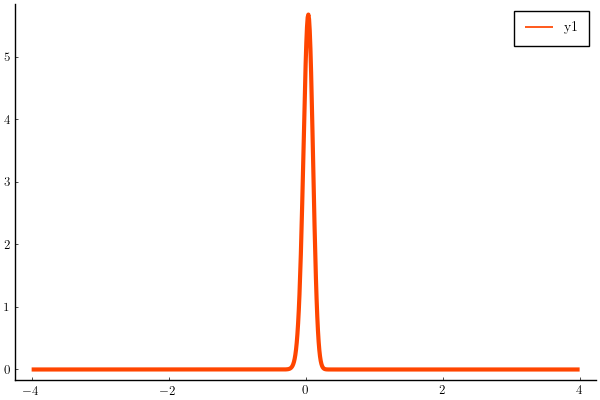

In [120]:
plot(xrange, exp.(log_pdf(My, Matrix(xrange'))), subplot = 1, linewidth = 3, color = :orangered)

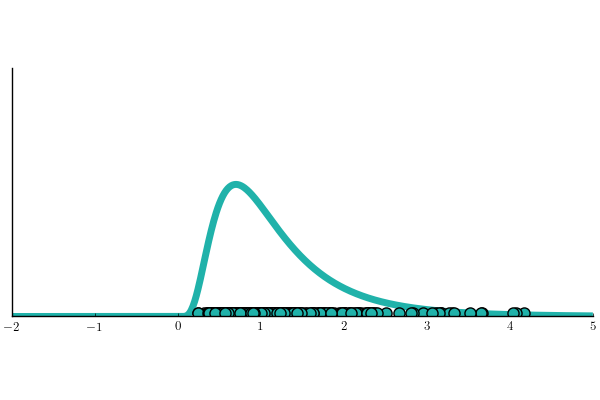

In [19]:
pltx = plot(xrange, pdf.(Dx, xrange), yticks = false, ylim = (0,1.5), xlim = (-Inf, Inf), ratio = 2.0, color = c_truth, 
        linewidth = 5, legend = false)
scatter!(pltx, samplex, 0.02*ones(Ne), markersize = 8, color = c_truth, label = "")
# savefig("prior.pdf")

In [25]:
m = 10
M = HermiteMap(m, X; diag = true);

In [26]:
optimize(M, X, "kfold"; withqr = true, withconstant = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


HermiteMap(10, 2, LinearTransform(2, [0.37392783885688413, 1.1779769046661597], [1.1697943248342781 0.0; 0.0 0.6938484516745387], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 10 active features
])

In [29]:
ystar = 0.5

0.5

In [31]:
Dlinear = fit_mle(Normal, samplex)

Normal{Float64}(μ=1.1779769046661597, σ=0.6926910723005247)

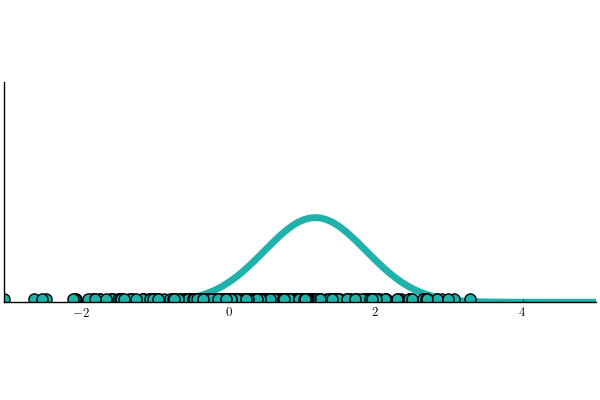

In [33]:
pltx = plot(xrange, pdf.(Dlinear, xrange), yticks = false, ylim = (0,1.5), xlim = (-Inf, Inf), ratio = 2.0, color = c_truth, 
        linewidth = 5, legend = false)
scatter!(pltx, X[1,:], 0.02*ones(Ne), markersize = 8, color = c_truth, label = "")
# savefig("prior.pdf")

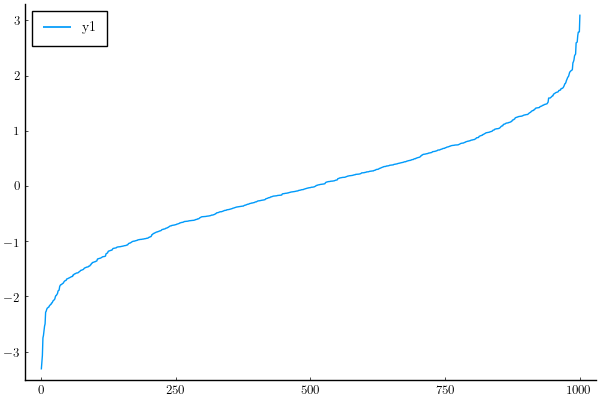

In [10]:
plot(sort(X[1,:]))

In [22]:
MpushX = evaluate(M, X)

2×1000 Array{Float64,2}:
  0.665442  -1.28691   -1.81054   …  0.766597  -0.046035   -0.19879
 -0.304935   0.247557  -0.523425     0.59017    0.0231977  -0.491153

In [23]:
S1 = Storage(M.C[1].I.f, X[1:1,:])
S2 = Storage(M.C[2].I.f, X[1:2,:]);

In [15]:
Nlog = 50
logbanana = zeros(Nlog, Nlog)
logbanana_x = zeros(Nlog)
logbanana_y = zeros(Nlog)
logbanana_approx = zeros(Nlog, Nlog)

lognormal = zeros(Nlog, Nlog)

a = 0.0
b = 1.0
c = 1.0


xrange = range(-5.0; stop = 5.0, length = Nlog)
yrange = range(-4.0; stop = 10.0, length = Nlog)

@showprogress for (i,x) in enumerate(xrange)
    for (j,y) in enumerate(yrange)
        logbanana[i,j] = log_pdf_banana([x;y], a = a, b = b, c = c)
        logbanana_x[i] = pdf(Normal(), a + b*x)
        logbanana_y[j] = pdf(Normal(), y - c*x^2)
        logbanana_approx[i,j] = log_pdf(M, reshape([x; y], (2,1)))[1]
        lognormal[i,j] = logpdf(MvNormal(zeros(2), 1.0), [x;y])
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


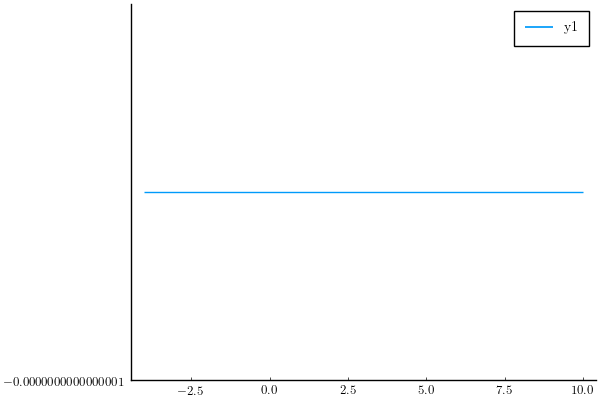

In [16]:
plot(yrange, logbanana_y)

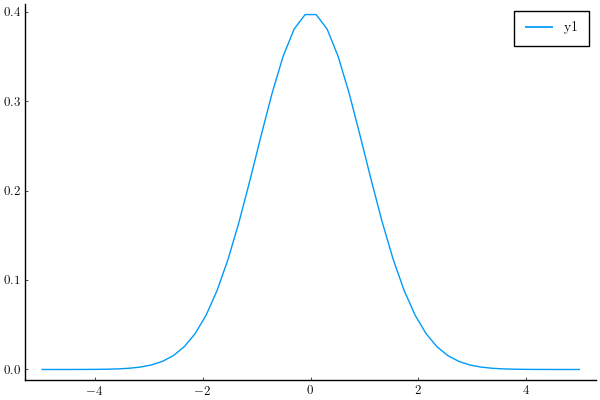

In [17]:
plot(xrange, logbanana_x)

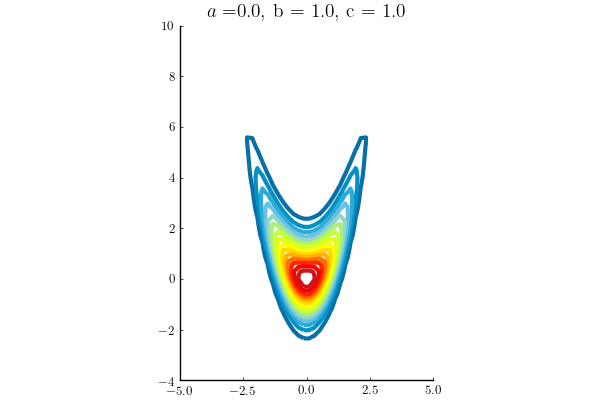

In [18]:
plt = plot(colorbar = false, grid = false)
contour!(plt, xrange, yrange, exp.(logbanana)', ratio = 1,
#          clim = (0.1, Inf),
#          levels = 9,
         title = L"a = "*string(a)*", b = "*string(b)*", c = "*string(c), 
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)
# savefig("banana_3.pdf")

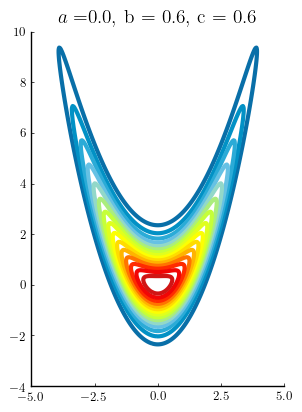

In [127]:
plt = plot(colorbar = false, grid = false)
contour!(plt, xrange, yrange, exp.(logbanana)', ratio = 1,
#          clim = (0.1, Inf),
#          levels = 9,
         title = L"a = "*string(a)*", b = "*string(b)*", c = "*string(c), 
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)
# savefig("banana_2.pdf")

In [ ]:
plt = plot(colorbar = false, grid = false)
contour!(plt, xrange, yrange, exp.(logbanana)', ratio = 1,
#          clim = (0.1, Inf),
#          levels = 9,
         title = L"a = "*string(a)*", b = "*string(b)*", c = "*string(c), 
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)
savefig("banana_2.pdf")

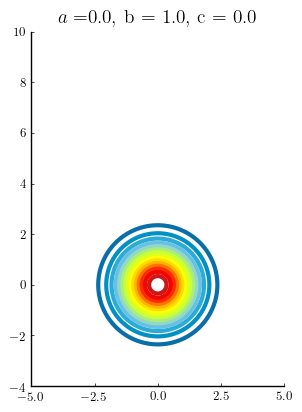

In [133]:
plt = plot(colorbar = false, grid = false)
contour!(plt, xrange, yrange, exp.(logbanana)', ratio = 1, 
#          levels = 20,
         title = L"a = "*string(a)*", b = "*string(b)*", c = "*string(c), 
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)
savefig("gaussian.pdf")

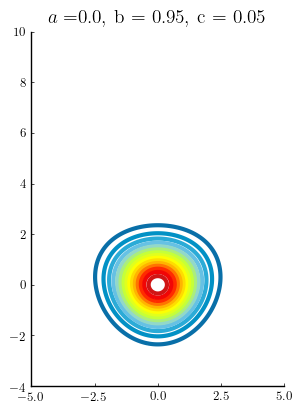

In [157]:
plt = plot(colorbar = false, grid = false)
contour!(plt, xrange, yrange, exp.(logbanana)', ratio = 1,
#          clim = (0.1, Inf),
#          levels = 9,
         title = L"a = "*string(a)*", b = "*string(b)*", c = "*string(c), 
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)
savefig("gaussian_approx.pdf")

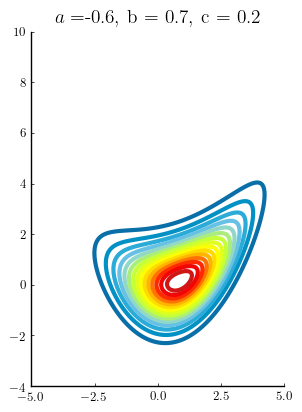

In [135]:
plt = plot(colorbar = false, grid = false)
contour!(plt, xrange, yrange, exp.(logbanana)', ratio = 1, 
#          clim = (0.05, Inf),
         title = L"a = "*string(a)*", b = "*string(b)*", c = "*string(c), 
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)
savefig("banana_1.pdf")

In [112]:
norm(exp.(logbanana)' - exp.(logbanana_approx)')/norm(exp.(logbanana)')

0.683932539316116

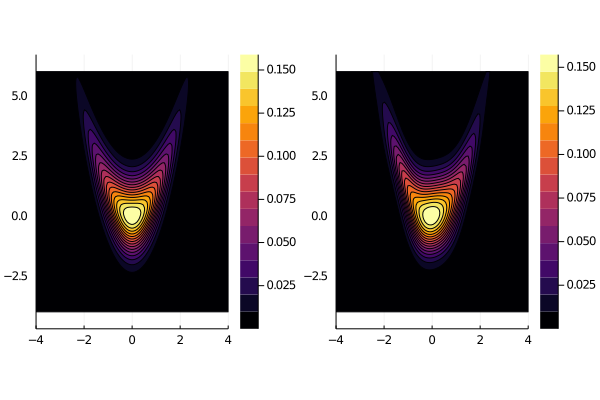

In [46]:
plt = plot(layout = grid(1,2))
contourf!(plt[1,1], xrange, yrange, exp.(logbanana)', ratio = 1, xlim = (xrange[1], xrange[end]))
# scatter!(X[1,:], X[2,:]; legend = false, color = :grey)

contourf!(plt[1,2], xrange, yrange, exp.(logbanana_approx)', ratio = 1, xlim = (xrange[1], xrange[end]))

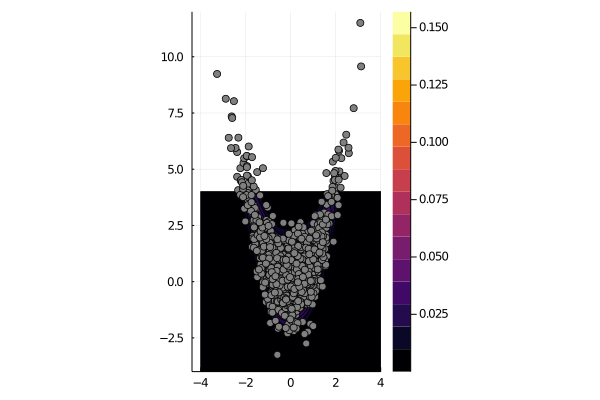

In [21]:
contourf(xrange, yrange, exp.(logbanana_approx)', ratio = 1, xlim = (-Inf, Inf), ylim = (-4, 12))
scatter!(X[1,:], X[2,:]; legend = false, color = :grey, ratio = 1)

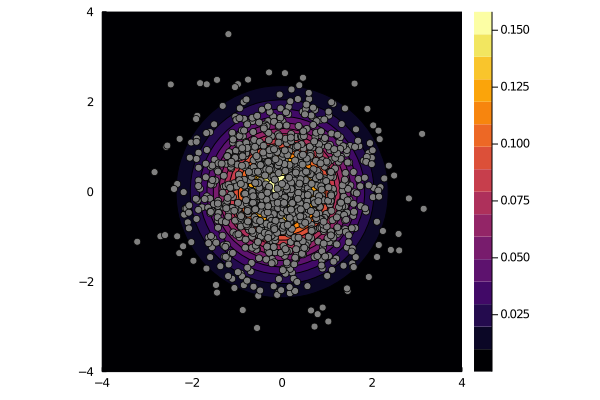

In [22]:
contourf(xrange, yrange, exp.(lognormal)', ratio = 1, xlim = (-4, 4),ylim = (-4, 4))
scatter!(MpushX[1,:], MpushX[2,:]; legend = false, color = :grey)

In [23]:
mean(MpushX; dims = 2)

2×1 Array{Float64,2}:
 -0.0048777388265290045
  0.00011520151984957305

In [24]:
cov(MpushX; dims = 2)

2×2 Array{Float64,2}:
  0.999968     -0.000653141
 -0.000653141   0.999085